# <img src="./logo_transparent.png" width="70"> Step7 - Analyse Equipes  <img src="./logoffhb.png" width="100"> 

In [4]:
from collections import defaultdict
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
pd.set_option('display.max_rows', None)
# %matplotlib widget

# Comptabilisation des actions du match (déroulé)

In [5]:
        # 0  ID TEXT NOT NULL PRIMARY KEY UNIQUE, 
        # 1  fichier TEXT,
        # 2  Journée INTEGER,
        # 3  equipe_dom TEXT,
        # 4  equipe_ext TEXT,
        # 5  Min TEXT,
        # 6  Sec TEXT,
        # 7  score_dom INTEGER,
        # 8  score_ext INTEGER,
        # 9  Action TEXT,
        # 10 Action_equipe TEXT,
        # 11 Numero TEXT,
        # 12 Joueur TEXT

In [6]:
championnat =[]
conn = sqlite3.connect('Championnat_U18_GrandEst.sqlite')
cur = conn.cursor()
cur.execute('SELECT * FROM Championnat ')  #WHERE Joueur = ? ', ('MORANDanthony',)
rows = cur.fetchall()
for row in rows:
    line ={}
    line['fichier']= row[1]
    line['Journée'] = row[2]
    line['equipe_dom']=row[3]
    line['equipe_ext']=row[4]
    line['Min']=row[5]
    line['Sec']=row[6]
    line['score_dom']=row[7]
    line['score_ext']=row[8]
    line['Action'] =row[9]
    line['Action_equipe'] =row[10]
    line['Joueur']=row[12]
    championnat.append(line)
conn.close()

In [7]:
print("Nombre d'actions du championnat:",len(championnat))

Nombre d'actions du championnat: 7954


In [8]:
df = pd.DataFrame(championnat)
df['Min']=df['Min'].astype(int)
df['Sec']=df['Sec'].astype(int)

In [9]:
df['Temps']=df['Min']+df['Sec']/60

In [10]:
def Analyse_j_m(dfjm):
    dom,ext ={},{}
    #print(len(dfjm))
    for t in ['Journée','fichier']:
        dom[t]= dfjm[t].unique()[0] 
        ext[t]= dfjm[t].unique()[0]
    dom['equipe']=dfjm['equipe_dom'].unique()[0]
    ext['equipe']=dfjm['equipe_ext'].unique()[0]
    #
    dfjms = dfjm.sort_values(by=['Temps'])
    dfjms['Diff_buts']=dfjms['score_dom']-dfjms['score_ext']
    #print(dfjms.iloc[-1])
    #
    # STATS
    dom['Nbre_Buts_marqués']=dfjms.iloc[-1]['score_dom']
    dom['Nbre_Buts_encaissés']=dfjms.iloc[-1]['score_ext']
    ext['Nbre_Buts_marqués']=dfjms.iloc[-1]['score_ext']
    ext['Nbre_Buts_encaissés']=dfjms.iloc[-1]['score_dom']
    dom['Diff_buts']=dom['Nbre_Buts_marqués']-dom['Nbre_Buts_encaissés']
    ext['Diff_buts']=ext['Nbre_Buts_marqués']-ext['Nbre_Buts_encaissés']
    #print('Check:',dom['Diff_buts']==dfjms['Diff_buts'].iloc[-1],ext['Diff_buts']==-dfjms['Diff_buts'].iloc[-1])
    #
    dom['Nb_Tirs']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action']=="Tir")].shape[0]
    ext['Nb_Tirs']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action']=="Tir")].shape[0]
    #
    dom['Nb_arrets']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action']=="Arrêt")].shape[0]
    ext['Nb_arrets']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action']=="Arrêt")].shape[0]
    #
    dom['Nb_2min']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action']=="2MN")].shape[0]
    ext['Nb_2min']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action']=="2MN")].shape[0]
    #
    dom['Nb_Av']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action']=="Avertissement")].shape[0]
    ext['Nb_Av']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action']=="Avertissement")].shape[0]
    #
    dom['Nb_Dis']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action']=="DisqualificationImmédiate")].shape[0]
    ext['Nb_Dis']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action']=="DisqualificationImmédiate")].shape[0]
    #
    dfjms['Delta_T'] = dfjms['Temps'].diff()
    dfjms.loc[dfjms.index[0],'Delta_T']=dfjms.loc[dfjms.index[0],'Temps'] # remplace la premiere valeur nan par le temps entre 0 et la premiere action
    Last_DeltaT = (60-dfjms.loc[dfjms.index[-1],'Temps'])
    #print('Check Temps total:', dfjms['Delta_T'].sum()+Last_DeltaT)
    #
    # TEMPS EN TETE, EGALITE, EN RETARD
    d,e,eg = 0,0,0
    if dfjms.loc[dfjms.index[-1],'Diff_buts']>0:
        d = Last_DeltaT
        dom['Points']=3 
        ext['Points']=1
    elif dfjms.loc[dfjms.index[-1],'Diff_buts']<0:
        e = Last_DeltaT
        ext['Points']=3 
        dom['Points']=1
    elif dfjms.loc[dfjms.index[-1],'Diff_buts']==0:
        e = Last_DeltaT
        dom['Points']=2
        ext['Points']=2
    dom['Temps_en_tête']= round(dfjms[(dfjms['Diff_buts']>0)]['Delta_T'].sum()+d,2)
    ext['Temps_en_tête']=round(dfjms[dfjms['Diff_buts']<0]['Delta_T'].sum()+e,2)
    dom['Temps_égalité']=round(dfjms[dfjms['Diff_buts']==0]['Delta_T'].sum()+eg,2)
    ext['Temps_égalité']=round(dfjms[dfjms['Diff_buts']==0]['Delta_T'].sum()+eg,2)
    #print('Check Temps total:',dom['Temps_en_tête']+ ext['Temps_en_tête']+dom['Temps_égalité'])
    #
    # TEMPS ENTRE 2 BUTS
    dfjms['Delta_T_buts_dom']=dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Temps'].diff()
    premier_but = dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action'].isin(["But","But7m"]))].index[0]
    dfjms.loc[premier_but,'Delta_T_buts_dom']=dfjms.loc[premier_but,'Temps']
    dom['Temps_moy_entre_2buts']=round(dfjms['Delta_T_buts_dom'].mean(),2)
    dom['Temps_max_entre_2buts']=round(dfjms['Delta_T_buts_dom'].max(),2)
    dom['Temps_min_entre_2buts']=round(dfjms['Delta_T_buts_dom'].min(),2)
    #print(dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].unique())
    dom['nb_marqueurs']=len(dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].unique())
    #
    dfjms['Delta_T_buts_ext']=dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Temps'].diff() 
    premier_but = dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action'].isin(["But","But7m"]))].index[0]
    dfjms.loc[premier_but,'Delta_T_buts_ext']=dfjms.loc[premier_but,'Temps']
    ext['Temps_moy_entre_2buts']=round(dfjms['Delta_T_buts_ext'].mean(),2)
    ext['Temps_max_entre_2buts']=round(dfjms['Delta_T_buts_ext'].max(),2)
    ext['Temps_min_entre_2buts']=round(dfjms['Delta_T_buts_ext'].min(),2)
    #print(dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].unique())
    ext['nb_marqueurs']=len(dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].unique())
    #
    # CRITERE COLLECTIF
    collectif_dom = dfjms[(dfjms['Action_equipe']==dom['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].value_counts()
    #print("median:",np.median(collectif_dom))
    moy = np.mean(collectif_dom)
    tot = [l*l-moy for l in collectif_dom]
    #print(collectif_dom, moy, len(collectif_dom),sum(collectif_dom),sum(tot)/len(collectif_dom))
    dom['Collectif']=sum(tot)/len(collectif_dom)
    collectif_ext = dfjms[(dfjms['Action_equipe']==ext['equipe']) & (dfjms['Action'].isin(["But","But7m"]))]['Joueur'].value_counts()
    #print("median:",np.median(collectif_dom))
    moy = np.mean(collectif_ext)
    tot = [l*l-moy for l in collectif_ext]
    #print(collectif_ext, moy, len(collectif_ext),sum(collectif_ext),sum(tot)/len(collectif_ext))
    ext['Collectif']=sum(tot)/len(collectif_ext)
    #
    #plt.plot(dfjms['Temps'],dfjms['score_dom'])
    #plt.plot(dfjms['Temps'],dfjms['score_ext'])
    #plt.plot(dfjms['Temps'],dfjms['Diff_buts'])
    #plt.legend([dom['equipe'],ext['equipe'],'Diff_buts'])
    #plt.grid()
    #
    #dfjms.to_csv('test.csv')
    return (dom,ext)
    

In [11]:
lst_match = df['fichier'].unique()
stat=[]
for l in lst_match:
        m=Analyse_j_m(df[df['fichier']==l])
        stat.append(m[0])
        stat.append(m[1])

In [12]:
df_stat=pd.DataFrame(stat)

In [13]:
df_stat

,Journée,fichier,equipe,Nbre_Buts_marqués,Nbre_Buts_encaissés,Diff_buts,Nb_Tirs,Nb_arrets,Nb_2min,Nb_Av,Nb_Dis,Points,Temps_en_tête,Temps_égalité,Temps_moy_entre_2buts,Temps_max_entre_2buts,Temps_min_entre_2buts,nb_marqueurs,Collectif
0,1,1_COLMAR HC U18M-EPINAL U18M.pdf,COLMAR HC U18M,31,20,11,21,6,3,2,0,3,49.92,4.17,1.91,4.78,0.38,10,11.600000
1,1,1_COLMAR HC U18M-EPINAL U18M.pdf,EPINAL U18M,20,31,-11,25,10,2,1,0,1,5.92,4.17,2.96,7.12,0.62,7,7.428571
2,1,1_ENT RIED'HANDBALL U18M-STRASBOURG&SCHILTIGHE...,ENT RIED'HANDBALL U18M,36,30,6,29,15,4,1,0,3,47.72,10.22,1.67,7.23,0.37,11,11.454545
3,1,1_ENT RIED'HANDBALL U18M-STRASBOURG&SCHILTIGHE...,STRASBOURG&SCHILTIGHEIM U18M2,30,36,-6,20,17,2,2,0,1,2.07,10.22,1.94,6.77,0.43,11,12.000000
4,1,1_THIONVILLE U18M-BASSIN MUSSIPONTAIN U18M.pdf,THIONVILLE U18M,28,26,2,9,17,0,1,0,3,59.37,0.63,2.09,8.48,0.40,6,29.666667
5,1,1_THIONVILLE U18M-BASSIN MUSSIPONTAIN U18M.pdf,BASSIN MUSSIPONTAIN U18M,26,28,-2,13,7,4,2,0,1,0.00,0.63,2.27,5.93,0.15,10,7.000000
6,1,1_ENT MULHOUSE ACADEMIE U18M2-HOCHFELDEN&DETTW...,ENT MULHOUSE ACADEMIE U18M2,29,30,-1,15,8,3,0,0,1,41.77,10.35,3.20,27.00,0.52,7,4.857143
7,1,1_ENT MULHOUSE ACADEMIE U18M2-HOCHFELDEN&DETTW...,HOCHFELDEN&DETTWILLER U18M,30,29,1,11,10,0,0,0,3,7.88,10.35,2.85,25.58,0.38,8,6.250000
8,1,1_METZ U18M-LINGOLSHEIM.pdf,METZ U18M,24,25,-1,25,11,1,2,0,1,11.57,15.02,2.51,10.87,0.55,5,22.400000
9,1,1_METZ U18M-LINGOLSHEIM.pdf,LINGOLSHEIM,25,24,1,25,11,6,0,0,3,33.42,15.02,2.16,6.32,0.47,10,8.200000


In [14]:
Journées = sorted(df_stat['Journée'].unique())

In [15]:
classement ={}
for j in Journées:
    classe= pd.pivot_table(df_stat[df_stat['Journée']<=j], index='equipe',values=['Points','Diff_buts'],aggfunc='sum')
    classe.sort_values(by=['Points','Diff_buts'],ascending=False, inplace=True)
    classement[j]=classe

In [16]:
lst_equipe = df_stat['equipe'].unique()

In [17]:
def plot_(Equipe_Analysée='EPINAL U18M'):
    stat_eq = df_stat[df_stat['equipe']==Equipe_Analysée].sort_values(by='Journée')
    fig,ax = plt.subplots(3, 2,figsize=(21,12),facecolor=(0.5,0.5,0.5))
    fig.suptitle(Equipe_Analysée,color=(1,1,1),size=35)
    #
    # EVOLUTION FORME
    clas = []
    for j in Journées:
        lst = classement[j].index.to_list()
        clas.append(lst.index(Equipe_Analysée)+1)
    x,y = 0,0
    ax[x,y].plot(Journées,clas,linestyle='-',c='b',marker='o')
    ax[x,y].bar(stat_eq['Journée'],stat_eq['Diff_buts'])
    ax[x,y].set_title("Evolution",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    ax[x,y].set_yticks([x for x in range(-25,25,5)])
    ax[x,y].set_ylim([-25, 25])
    ax[x,y].legend(['Position au Classement','Diff_buts'])
    #
    # STAT
    x,y = 0,1
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nbre_Buts_marqués'],linestyle='-',c='b',marker='o')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nbre_Buts_encaissés'],linestyle='-',c='r',marker='s')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nb_arrets'],linestyle='-',c='g',marker='*')
    ax[x,y].set_title("Statistiques",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    ax[x,y].set_yticks([x for x in range(0,50,10)])
    ax[x,y].legend(['Nbre_Buts_marqués','Nbre_Buts_encaissés','Nb_arrets'])
    #
    # DISCIPLINE
    x,y = 1,1
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nb_Dis'],linestyle='-',c='b',marker='o')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nb_2min'],linestyle='-',c='r',marker='s')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Nb_Av'],linestyle='-',c='g',marker='*')
    ax[x,y].set_title("Discipline",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    ax[x,y].set_yticks([x for x in range(0,10,1)])
    ax[x,y].legend(['Nb_Dis','Nb_2min','Nb_Av'])
    #
    # RESILIENCE
    x,y = 1,0
    for j,diff,t in zip(stat_eq['Journée'],stat_eq['Diff_buts'],stat_eq['Temps_en_tête']):
        if diff>0: col ='g'
        elif diff<0: col ='r'
        else: col='y'
        ax[x,y].bar(j,t,color=col)
    #ax[x,y].text(stat_eq['Journée'],stat_eq['Temps_en_tête'],stat_eq['Diff_buts'])
    ax[x,y].set_title("Resilience",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    if stat_eq.iloc[0]['Diff_buts']>0:
        ax[x,y].legend(['Temps_en_tête, match gagné','Temps_en_tête, match perdu'])
    elif stat_eq.iloc[0]['Diff_buts']<0:
        ax[x,y].legend(['Temps_en_tête, match perdu','Temps_en_tête, match gagné'])
    #
    # REGULARITE
    x,y = 2,0
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Temps_moy_entre_2buts'],linestyle='-',c='b',marker='o')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Temps_min_entre_2buts'],linestyle='-',c='r',marker='s')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Temps_max_entre_2buts'],linestyle='-',c='g',marker='*')
    ax[x,y].set_title("Regularité",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    ax[x,y].set_yticks([x for x in range(0,16,2)])
    ax[x,y].legend(['Temps_moy_entre_2buts','Temps_min_entre_2buts','Temps_max_entre_2buts'])
    #
    # COLLECTIF
    x,y = 2,1
    ax[x,y].plot(stat_eq['Journée'],stat_eq['nb_marqueurs'],linestyle='-',c='b',marker='o')
    ax[x,y].plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',c='g',marker='s')
    ax[x,y].set_title("Collectif",color=(1,1,1))
    ax[x,y].grid()
    ax[x,y].set_xticks([x for x in range(1,23,1)])
    ax[x,y].set_yticks([x for x in range(0,45,5)])
    ax[x,y].legend(['nb_marqueurs','Collectif'])
    fig.savefig('./ANALYSE/'+Equipe_Analysée+".jpg", dpi=400)

interactive(children=(Dropdown(description='Equipe_Analysée', index=1, options=('COLMAR HC U18M', 'EPINAL U18M…

<function __main__.plot_(Equipe_Analysée='EPINAL U18M')>

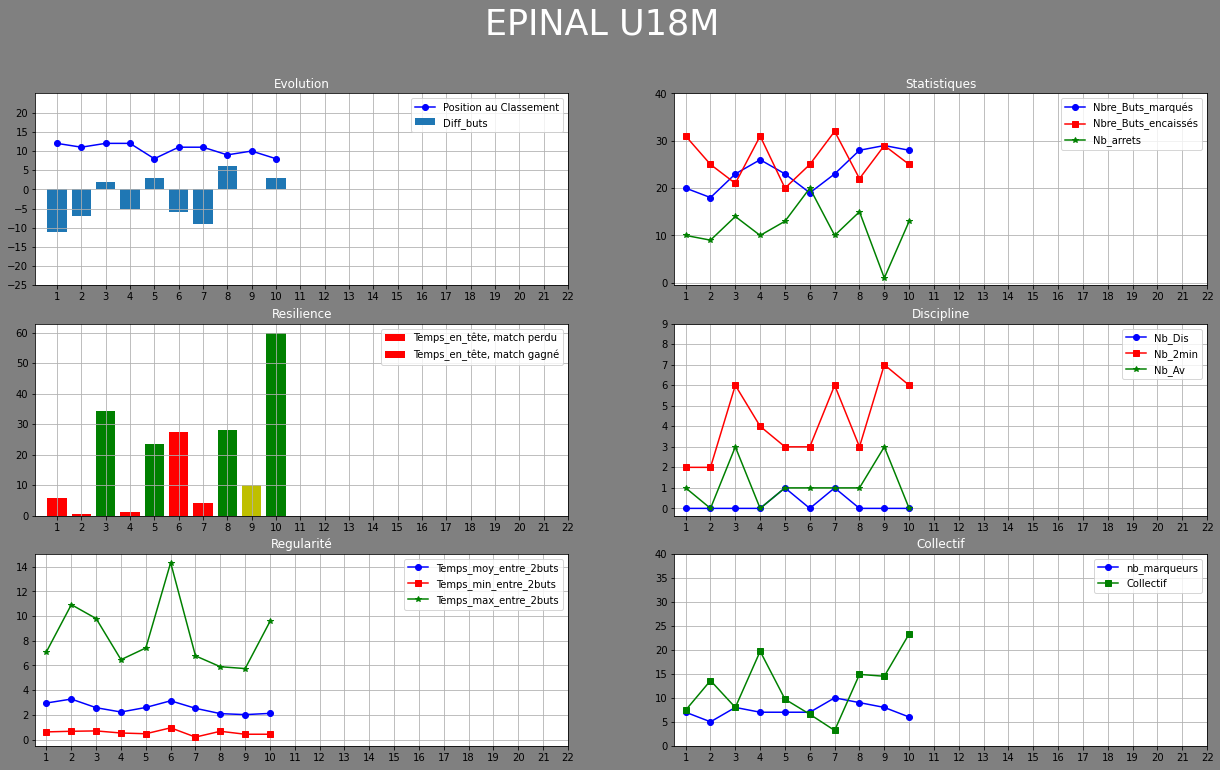

In [18]:
widgets.interact(plot_, Equipe_Analysée=lst_equipe)

# All Teams

In [19]:
def plot_class(Equipe_Analysée='EPINAL U18M'): 
    fi =plt.figure(figsize=(21,12))
    for e in lst_equipe:
        #stat_eq = df_stat[df_stat['equipe']==e].sort_values(by='Journée')
        if e==Equipe_Analysée:
            clas = []
            for j in Journées:
                lst = classement[j].index.to_list()
                clas.append(lst.index(e)+1)
            plt.plot(Journées,clas,linestyle='-',linewidth=5,marker='o')
        else:
            clas = []
            for j in Journées:
                lst = classement[j].index.to_list()
                clas.append(lst.index(e)+1)
            plt.plot(Journées,clas,linestyle='-',linewidth=2,marker='o')

    plt.grid()
    plt.legend(lst_equipe)
    plt.xlabel('Journée')
    plt.ylabel('Position au Classment')
    plt.yticks([x for x in range(1,13,1)])

interactive(children=(Dropdown(description='Equipe_Analysée', index=1, options=('COLMAR HC U18M', 'EPINAL U18M…

<function __main__.plot_class(Equipe_Analysée='EPINAL U18M')>

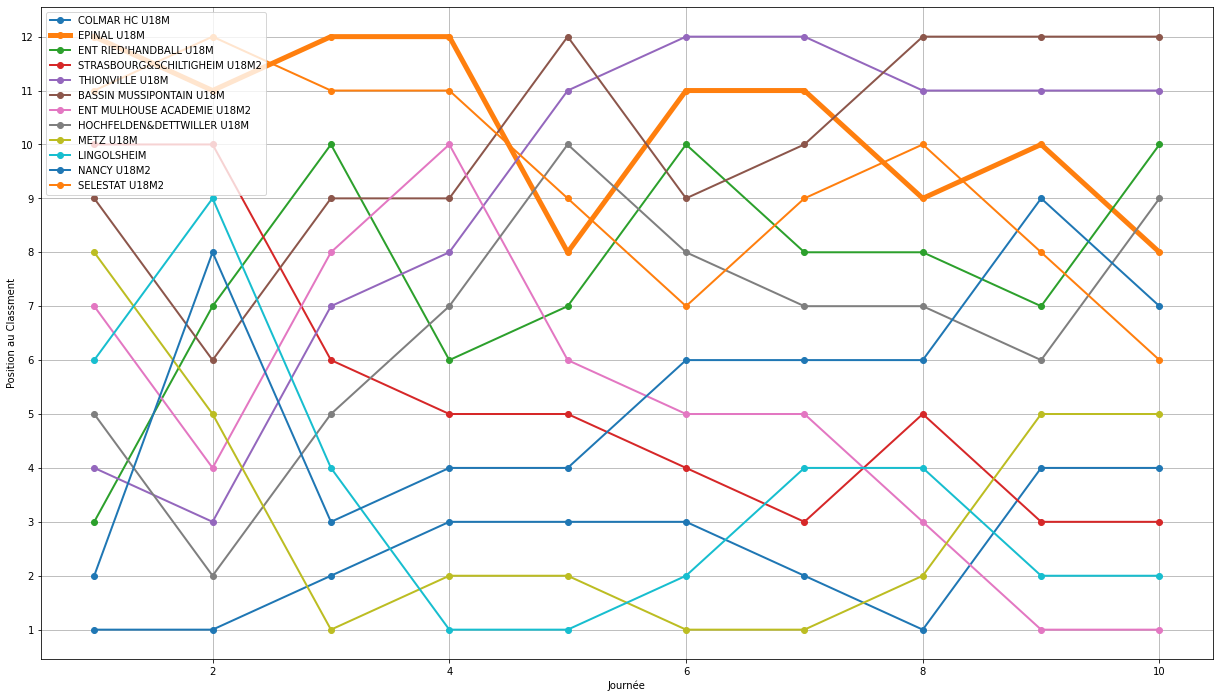

In [20]:
widgets.interact(plot_class, Equipe_Analysée=lst_equipe)

In [21]:
def plot_nbmarqueurs(Equipe_Analysée='EPINAL U18M'):
    fi =plt.figure(figsize=(21,12))
    for e in lst_equipe:
        stat_eq = df_stat[df_stat['equipe']==e].sort_values(by='Journée')
        if e==Equipe_Analysée:
            plt.plot(stat_eq['Journée'],stat_eq['nb_marqueurs'],linestyle='-',linewidth=5,marker='o')
        else:
            plt.plot(stat_eq['Journée'],stat_eq['nb_marqueurs'],linestyle='-',linewidth=1,marker='o')
    plt.grid()
    plt.legend(lst_equipe)
    plt.xlabel('Journée')
    plt.ylabel('Nombre de marqeurs')
    plt.yticks([x for x in range(1,13,1)])

interactive(children=(Dropdown(description='Equipe_Analysée', index=1, options=('COLMAR HC U18M', 'EPINAL U18M…

<function __main__.plot_nbmarqueurs(Equipe_Analysée='EPINAL U18M')>

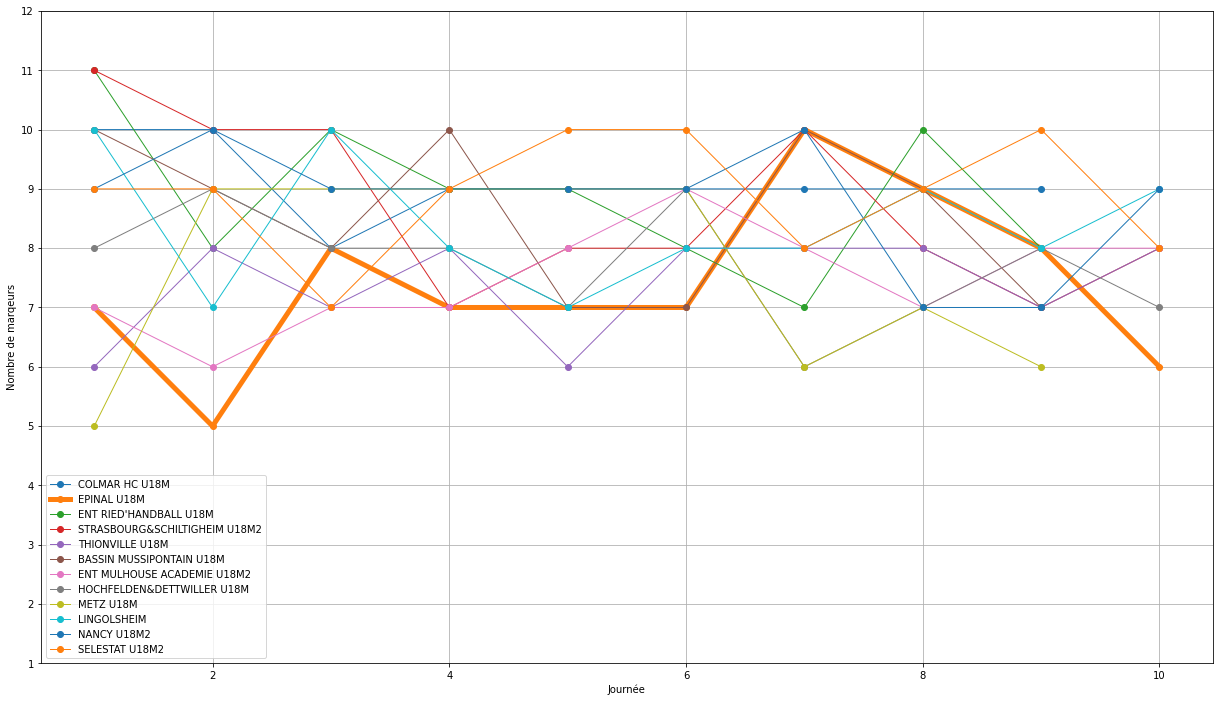

In [22]:
widgets.interact(plot_nbmarqueurs, Equipe_Analysée=lst_equipe)

In [23]:
def plot_collectif(Equipe_Analysée='EPINAL U18M'):
    fi =plt.figure(figsize=(21,12))
    coll={}
    for e in lst_equipe:
        stat_eq = df_stat[df_stat['equipe']==e].sort_values(by='Journée')
        if e==Equipe_Analysée:
            plt.plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',linewidth=5,marker='o')
        else:
            plt.plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',linewidth=1,marker='o')
        print("Collectif moyen de",e,round(stat_eq['Collectif'].mean(),1))
        coll[e]=round(stat_eq['Collectif'].mean(),1)
    plt.grid()
    plt.legend(lst_equipe)
    plt.xlabel('Journée')
    plt.ylabel('Collectif moyen')
    #plt.yticks([x for x in range(1,13,1)])

interactive(children=(Dropdown(description='Equipe_Analysée', index=1, options=('COLMAR HC U18M', 'EPINAL U18M…

<function __main__.plot_collectif(Equipe_Analysée='EPINAL U18M')>

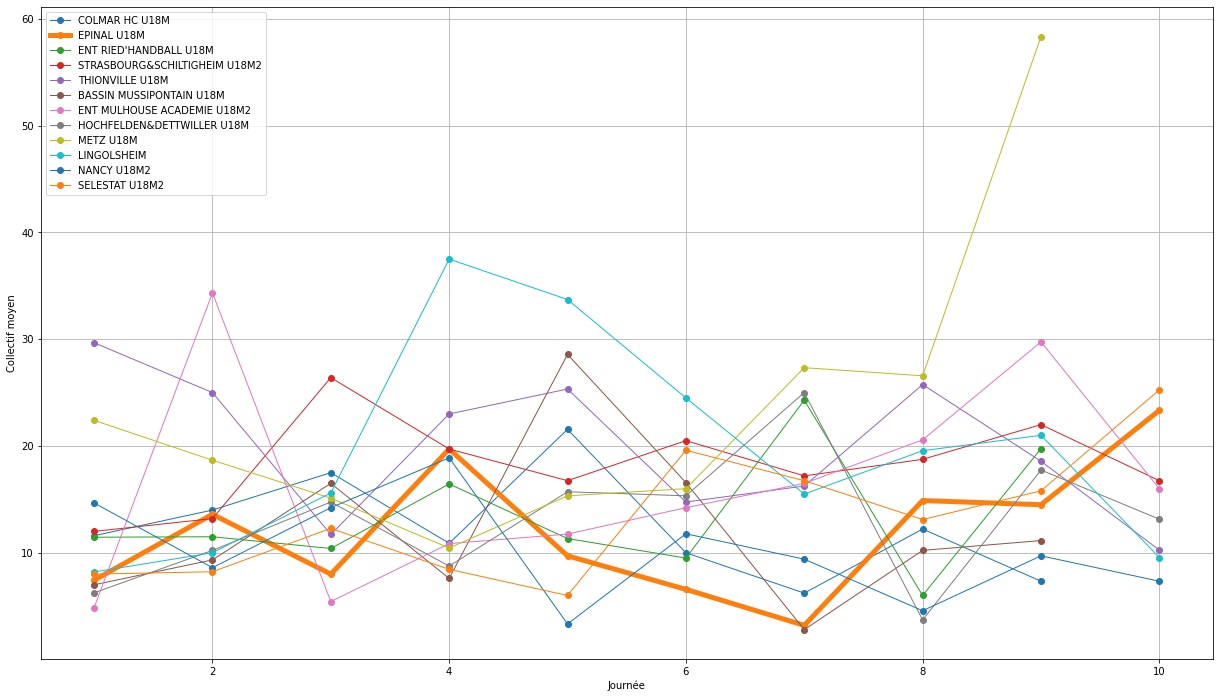

In [24]:
widgets.interact(plot_collectif, Equipe_Analysée=lst_equipe)

In [25]:
def plot_compare(Equipe_Analysée='EPINAL U18M',critere =''):
    fi =plt.figure(figsize=(21,12))
    coll={}
    for e in lst_equipe:
        stat_eq = df_stat[df_stat['equipe']==e].sort_values(by='Journée')
        if e==Equipe_Analysée:
            plt.plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',linewidth=5,marker='o')
        else:
            plt.plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',linewidth=1,marker='o')
        print("Collectif moyen de",e,round(stat_eq['Collectif'].mean(),1))
        coll[e]=round(stat_eq['Collectif'].mean(),1)
    plt.grid()
    plt.legend(lst_equipe)
    plt.xlabel('Journée')
    plt.ylabel('Position au Classment')
    #plt.yticks([x for x in range(1,13,1)])

In [26]:
plt.plot(stat_eq['Journée'],stat_eq['Collectif'],linestyle='-',linewidth=5,marker='o')

NameError: name 'stat_eq' is not defined